In [1]:
!pip install pretrainedmodels
!pip install albumentations==0.4.6

     |████████████████████████████████| 61kB 5.0MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=4d3a89a79fcbadd841d1d47de80ff2b8dcba76665875c161b0cc5a508c8f64ca
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
     |████████████████████████████████| 122kB 8.8MB/s 
     |████████████████████████████████| 952kB 34.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=9980962cbe9f44193b946e4bb1d5e1d03ed5dc5d6e2ae72770a4ae382251c167
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
 

In [2]:
import os
import numpy as np
import pandas as pd

import albumentations as A
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

import pretrainedmodels

from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from albumentations import Rotate 

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import warnings  
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DIR_INPUT = '/content/drive/MyDrive/DSPD Project/Data/'

SEED = 42
N_FOLDS = 3
N_EPOCHS = 5
BATCH_SIZE = 64
SIZE = 512



In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
class PlantDataset(Dataset):
    
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms=transforms
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        image_src = DIR_INPUT + '/images/' + self.df.loc[idx, 'image_id'] + '.jpg'
        # print(image_src)
        image = cv2.imread(image_src, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        labels = self.df.loc[idx, ['healthy', 'multiple_diseases', 'rust', 'scab']].values
        labels = torch.from_numpy(labels.astype(np.int8))
        labels = labels.unsqueeze(-1)
        
        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']

        return image, labels

In [7]:
transforms_train = A.Compose([
        A.RandomResizedCrop(height=SIZE, width=SIZE, p=1.0),
        A.Rotate(20),
        A.Flip(),
        A.Transpose(),
    A.Resize(height=SIZE, width=SIZE, p=1.0),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0),
    ], p=1.0)

transforms_valid = A.Compose([
    A.Resize(height=SIZE, width=SIZE, p=1.0),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0),
])

In [8]:
train_df = pd.read_csv(DIR_INPUT + '/train.csv')
train_labels = train_df.iloc[:, 1:].values

# Need for the StratifiedKFold split
train_y = train_labels[:, 2] + train_labels[:, 3] * 2 + train_labels[:, 1] * 3

In [9]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [10]:
folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
oof_preds = np.zeros((train_df.shape[0], 4))

In [11]:
model_name = 'resnet34'
model = pretrainedmodels.__dict__[model_name](pretrained='imagenet')
in_features = model.last_linear.in_features
model.last_linear = nn.Linear(in_features, 4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [12]:
class DenseCrossEntropy(nn.Module):

    def __init__(self):
        super(DenseCrossEntropy, self).__init__()
        
        
    def forward(self, logits, labels):
        logits = logits.float()
        labels = labels.float()
        
        logprobs = F.log_softmax(logits, dim=-1)
        
        loss = -labels * logprobs
        loss = loss.sum(-1)

        return loss.mean()

In [13]:
def train_one_fold(i_fold, model, criterion, optimizer, lr_scheduler, dataloader_train, dataloader_valid):
    
    train_fold_results = []

    for epoch in range(N_EPOCHS):

        print('  Epoch {}/{}'.format(epoch + 1, N_EPOCHS))
        print('  ' + ('-' * 20))
        os.system(f'echo \"  Epoch {epoch}\"')

        model.train()
        tr_loss = 0

        for step, batch in enumerate(dataloader_train):

            images = batch[0].to(device)
            labels = batch[1].to(device)

            images = images.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)
            
            outputs = model(images)
            loss = criterion(outputs, labels.squeeze(-1))                
            loss.backward()

            tr_loss += loss.item()

            optimizer.step()
            optimizer.zero_grad()

        # Validate
        model.eval()
        val_loss = 0
        val_preds = None
        val_labels = None

        for step, batch in enumerate(dataloader_valid):

            images = batch[0]
            labels = batch[1]

            if val_labels is None:
                val_labels = labels.clone().squeeze(-1)
            else:
                val_labels = torch.cat((val_labels, labels.squeeze(-1)), dim=0)

            images = images.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            with torch.no_grad():
                outputs = model(images)

                loss = criterion(outputs, labels.squeeze(-1))
                val_loss += loss.item()

                preds = torch.softmax(outputs, dim=1).data.cpu()

                if val_preds is None:
                    val_preds = preds
                else:
                    val_preds = torch.cat((val_preds, preds), dim=0)
       
        # if train mode
        lr_scheduler.step(tr_loss)

        train_fold_results.append({
            'fold': i_fold,
            'epoch': epoch,
            'train_loss': tr_loss / len(dataloader_train),
            'valid_loss': val_loss / len(dataloader_valid),
            'valid_score': roc_auc_score(val_labels, val_preds, average='macro'),
        })

    return val_preds, train_fold_results

In [14]:
submission_df = pd.read_csv(DIR_INPUT + '/sample_submission.csv')
submission_df.iloc[:, 1:] = 0

In [15]:
dataset_test = PlantDataset(df=submission_df, transforms=transforms_valid)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

In [16]:
submissions = None
train_results = []

for i_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, train_y)):
    print("Fold {}/{}".format(i_fold + 1, N_FOLDS))

    valid = train_df.iloc[valid_idx]
    valid.reset_index(drop=True, inplace=True)

    train = train_df.iloc[train_idx]
    train.reset_index(drop=True, inplace=True)    

    dataset_train = PlantDataset(df=train, transforms=transforms_train)
    dataset_valid = PlantDataset(df=valid, transforms=transforms_valid)

    dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

    #device = torch.device("cuda:0")
    
    model = model.to(device)

    criterion = DenseCrossEntropy()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[int(N_EPOCHS * 0.5), int(N_EPOCHS * 0.75)], gamma=0.1, last_epoch=-1)
    
    val_preds, train_fold_results = train_one_fold(i_fold, model, criterion, optimizer, lr_scheduler, dataloader_train, dataloader_valid)
    oof_preds[valid_idx, :] = val_preds.numpy()
    
    train_results = train_results + train_fold_results

    model.eval()
    test_preds = None

    for step, batch in enumerate(dataloader_test):

        images = batch[0]
        images = images.to(device, dtype=torch.float)

        with torch.no_grad():
            outputs = model(images)

            if test_preds is None:
                test_preds = outputs.data.cpu()
            else:
                test_preds = torch.cat((test_preds, outputs.data.cpu()), dim=0)
    
    
    # Save predictions per fold
    submission_df[['healthy', 'multiple_diseases', 'rust', 'scab']] = torch.softmax(test_preds, dim=1)
    submission_df.to_csv('submission_fold_{}.csv'.format(i_fold), index=False)

    # logits avg
    if submissions is None:
        submissions = test_preds / N_FOLDS
    else:
        submissions += test_preds / N_FOLDS

print("Folds CV score: {:.4f}".format(roc_auc_score(train_labels, oof_preds, average='macro')))

torch.save(model.state_dict(), 'best_score_rnn34.pth')

Fold 1/3
  Epoch 1/5
  --------------------
  Epoch 2/5
  --------------------
  Epoch 3/5
  --------------------
  Epoch 4/5
  --------------------
  Epoch 5/5
  --------------------
Fold 2/3
  Epoch 1/5
  --------------------
  Epoch 2/5
  --------------------
  Epoch 3/5
  --------------------
  Epoch 4/5
  --------------------
  Epoch 5/5
  --------------------
Fold 3/3
  Epoch 1/5
  --------------------
  Epoch 2/5
  --------------------
  Epoch 3/5
  --------------------
  Epoch 4/5
  --------------------
  Epoch 5/5
  --------------------
Folds CV score: 0.9140


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/DSPD Project/Data/models/best_score_rnn34.pth')

In [17]:
import matplotlib.pyplot as plt

In [18]:
def show_training_loss(train_result):
    plt.figure(figsize=(15,10))
    plt.subplot(311)
    train_loss = train_result['train_loss']
    plt.plot(train_loss.index, train_loss, label = 'train_loss')
    plt.legend()

    val_loss = train_result['valid_loss']
    plt.plot(val_loss.index, val_loss, label = 'val_loss')
    plt.legend()

In [19]:
def show_valid_score(train_result):
    plt.figure(figsize=(15,10))
    plt.subplot(311)
    valid_score = train_result['valid_score']
    plt.plot(valid_score.index, valid_score, label = 'valid_score')
    plt.legend()

In [20]:
train_results = pd.DataFrame(train_results)
train_results.head(10)

,fold,epoch,train_loss,valid_loss,valid_score
0,0,0,0.766533,2.958302,0.767438
1,0,1,0.433636,0.369256,0.902839
2,0,2,0.422984,0.359112,0.908212
3,0,3,0.412661,0.359680,0.910267
4,0,4,0.399907,0.350144,0.911758
5,1,0,0.787325,0.958325,0.784450
6,1,1,0.624129,0.623101,0.891888
7,1,2,0.559434,0.519115,0.914656
8,1,3,0.513363,0.479335,0.920183
9,1,4,0.468036,0.457944,0.919906


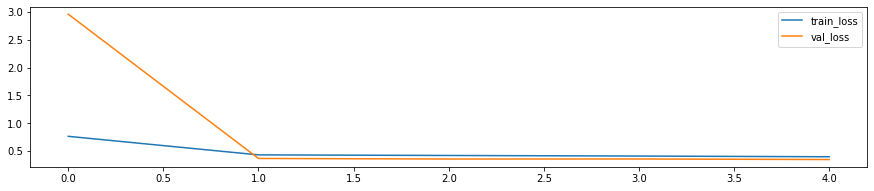

In [21]:
show_training_loss(train_results[train_results['fold'] == 0])

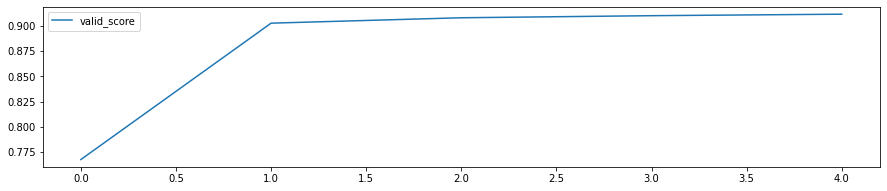

In [22]:
show_valid_score(train_results[train_results['fold'] == 0])